In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import pickle
import numpy as np
from scipy.stats import pearsonr, t
from scipy.stats.mstats import pearsonr as nanpeasonr
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from tqdm import tnrange

In [3]:
import cvtk.variant_files as vf

In [4]:
plt.style.use('./buffalo.mplstyle')

In [5]:
VCF_FILE = '../data/bergland_et_al_2014/6d_v7.3_output_fixed_filtered.vcf.gz'

sf = vf.AD_DP_VCFFile(VCF_FILE)
gi = sf.build_gintervals()

reading file '../data/bergland_et_al_2014/6d_v7.3_output_fixed_filtered.vcf.gz'...
file '../data/bergland_et_al_2014/6d_v7.3_output_fixed_filtered.vcf.gz' loaded.
total time to load VCF file: 0.18108654816945394 mins.


### Parse the CSV INFO field

In [6]:
cols = ['CHROM','POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 
        'FORMART', 'FL1', 'FL2', 'GA', 'SC', 'NC', 'ME1', 'ME2', 'PA_7_2009',
        'PA_11_2009', 'PA_7_2010', 'PA_11_2010', 'PA_7_2011', 'PA_10_2011', 'PA_11_2011']
d = pd.read_csv(VCF_FILE, delimiter='\t', comment='#', names=cols, index_col=False)

In [7]:
def parse_info(x):
    rows = []
    for line in x:
        rows.append(dict([tuple(x.split('=')) for x in line.split(';')]))
    return rows

rows = parse_info(d['INFO'].values)
# original seasonal p-values
SP = np.array([float(x['SP']) for x in rows])

In [8]:
depths = sf.mat.sum(axis=2)

In [9]:
diploids = np.array([39, 48, 51, 48, 46, 86, 75, 55, 74, 116, 33, 75, 47, 50])
nchr = 2*diploids

## GLM Analysis of Seasonal Data

We extract the sample months (for Fall / Spring labels) and indices from the original sample names:

In [10]:
indices, samples = zip(*[(i, x.split('_')[1]) for i, x in enumerate(sf.samples) if x.startswith('PA_')])
indices, samples = np.array(indices)[:-1], np.array(samples)[:-1]
print(dict(zip(indices, samples)))

{7: '7', 8: '11', 9: '7', 10: '11', 11: '7', 12: '10'}


In [11]:
def Neff(depth, nchr):
    return np.floor((nchr * depth - 1) / (nchr + depth))

In [12]:
def seasonal_model(freqs, model_matrix, Neff, constant=True):
    if constant:
        model_matrix = sm.add_constant(model_matrix)
    m = sm.GLM(freqs, model_matrix, var_weights=Neff, family=sm.families.Binomial())
    return m

# For spring, we use 1, Fall 0
seasonal_model_matrix = np.array([{'7': 1, '11': 0, '10':0}[x] for x in samples], dtype='int64')
seasonal_model_matrix

array([1, 0, 1, 0, 1, 0])

In [13]:
def apply_model(mat, model, model_matrix, nchr, progress=True, permute=False, **kwargs):
    depth = mat.sum(axis=2)
    freqs = mat[:, :, 0] / depth    
    Neff_weights = Neff(depth, nchr)
    nloci = mat.shape[0]
    models = []
    #nloci = 10000  # for testing
    loci_range = range(nloci) if not progress else tnrange(nloci)
    for l in loci_range:
        #import pdb; pdb.set_trace()
        if permute:
            model_matrix = np.random.permutation(model_matrix)
        m = model(freqs[l, ...], model_matrix=model_matrix, Neff=Neff_weights[l, ...], **kwargs)
        models.append(m.fit())
    return models

In [14]:
CACHE_GLMFITS = '../data/bergland_et_al_2014/bergland_glmfits_per_locus.pkl'
FORCE = False

if FORCE or not os.path.exists(CACHE_GLMFITS):
    loci_models = apply_model(sf.mat[:, indices, :], seasonal_model, seasonal_model_matrix, nchr[indices], constant=True)
    with open(CACHE_GLMFITS, 'wb') as f:
        pickle.dump(loci_models, f)
else:
     with open(CACHE_GLMFITS, 'rb') as f:
        loci_models = pickle.load(f)

In [ ]:
pvals = np.array([f.pvalues[1] for f in loci_models])

Save the p-values from the original study, and our re-analysis p-values.

In [18]:
pval_comparison = pd.DataFrame(dict(bergland_pvals=SP, our_pvals=pvals))
pval_comparison.to_feather('../data/bergland_et_al_2014/bergland_pvalue_comparison.feather')
pval_comparison.to_csv('../data/bergland_et_al_2014/bergland_pvalue_comparison.csv')

## Permutation Analysis

## Permuting Seasons per Locus

In [19]:
NREPS = 5

In [20]:
CACHE_PERMUTATION = '../data/bergland_et_al_2014/bergland_permutation_per_locus.pkl'

if FORCE or not os.path.exists(CACHE_PERMUTATION):
    permuted_loci_models = []

    for rep in tnrange(NREPS):
        res = apply_model(sf.mat[:, indices, :], seasonal_model, seasonal_model_matrix,
                           nchr=nchr[indices], permute=True, constant=True)
        permuted_loci_models.append(res)
    with open(CACHE_PERMUTATION, 'wb') as f:
        pickle.dump(permuted_loci_models, f)
else:
     with open(CACHE_PERMUTATION, 'rb') as f:
        permuted_loci_models = pickle.load(f)

In [24]:
locus_permuted_pvals = np.array([[f.pvalues[1] for f in res] for res in permuted_loci_models])

In [26]:
with open('../data/bergland_et_al_2014/locus_level_permutation_pvalues.npy', 'wb') as f:
    np.save(f, locus_permuted_pvals)

### Permuting Seasons Once Per Run

In [ ]:
CACHE_PERMUTATION_REP = '../data/bergland_et_al_2014/bergland_permutation_per_rep.pkl'
NREPS = 5

if FORCE or not os.path.exists(CACHE_PERMUTATION_REP):
    permuted_rep_models = []

    for rep in tnrange(NREPS):
        permuted_seasonal_model_matrix = np.random.permutation(seasonal_model_matrix)
        res = apply_model(sf.mat[:, indices, :], seasonal_model, permuted_seasonal_model_matrix,
                           nchr=nchr[indices], permute=True, constant=True)
        permuted_rep_models.append(res)
else:
     with open(CACHE_PERMUTATION_REPe, 'rb') as f:
        permuted_rep_models = pickle.load(f)

In [ ]:
rep_permuted_pvals = np.array([[f.pvalues[1] for m, f in res] for res in permuted_rep_models])

In [ ]:
with open('../data/bergland_et_al_2014/rep_level_permutation_pvalues.npy', 'wb') as f:
    np.save(f, rep_permuted_pvals)

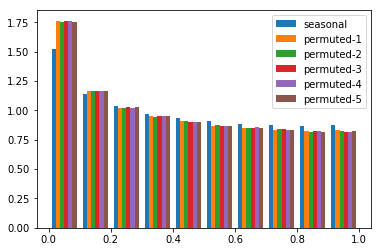

In [72]:
labels = tuple(['seasonal'] + [f'permuted-{r+1}' for r in range(NREPS)])
plt.hist(np.hstack((pvals.reshape(-1, 1), permuted2_pvals.T)), density=True, label=labels)
plt.legend()